## STARE (podział danych na balanced animals)


In [4]:
# from pathlib import Path
# import random
# import shutil
#
# NUM_FILES = 2503
#
# # BASE_DIR = folder, w którym jest notebook
# BASE_DIR = Path().resolve()
#
# SOURCE = BASE_DIR / "dataset" / "animals"
# DEST = BASE_DIR / "dataset" / "animals_balanced"
#
# DEST.mkdir(parents=True, exist_ok=True)
#
# images = [f for f in SOURCE.iterdir() if f.suffix.lower() in [".jpg", ".jpeg", ".png"]]
#
# print("BASE_DIR:", BASE_DIR)
# print("SOURCE:", SOURCE)
# print("DEST:  ", DEST)
# print("Liczba zdjęć w animals:", len(images))
#
# if len(images) < NUM_FILES:
#     raise ValueError(f"Za mało zdjęć w animals: {len(images)} < {NUM_FILES}")
#
# random.seed(42)
# selected = random.sample(images, NUM_FILES)
#
# for src_path in selected:
#     dst_path = DEST / src_path.name
#     shutil.copy2(src_path, dst_path)
#
# print(f"Gotowe! Skopiowano {NUM_FILES} zdjęć do: {DEST}")


BASE_DIR: D:\PROJECTS\PythonProjects\EWD_Project
SOURCE: D:\PROJECTS\PythonProjects\EWD_Project\dataset\animals
DEST:   D:\PROJECTS\PythonProjects\EWD_Project\dataset\animals_balanced
Liczba zdjęć w animals: 5400
Gotowe! Skopiowano 2503 zdjęć do: D:\PROJECTS\PythonProjects\EWD_Project\dataset\animals_balanced


## Class Weights

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pathlib
import os

# --- 1. Konfiguracja ścieżek i parametrów ---
image_size = (256, 256)
batch_size = 32
dataset_dir = pathlib.Path("dataset")

# Definiujemy nazwy folderów, których chcemy użyć
# Kolejność jest ważna: 0 = pokemon, 1 = animals
target_classes = ["pokemon", "animals"]

# --- 2. Obliczanie liczby zdjęć i wag klas (Class Weights) ---
# Musimy to zrobić, bo zwierząt jest ~5400, a pokemonów ~2500.
# Bez tego model zgadywałby częściej "zwierzę", bo jest ich więcej.

print("--- Liczenie plików ---")
counts = {}
for cls in target_classes:
    cls_path = dataset_dir / cls
    # Liczymy pliki jpg, jpeg, png
    count = len([f for f in cls_path.glob('*') if f.suffix.lower() in ['.jpg', '.jpeg', '.png']])
    counts[cls] = count
    print(f"Klasa '{cls}': {count} zdjęć")

total_images = sum(counts.values())
count_pokemon = counts["pokemon"]
count_animals = counts["animals"]

# Wzór na wagi: (1 / liczność) * (total / 2)
# Sprawia, że obie klasy mają taki sam wpływ na "loss" (błąd) modelu.
weight_for_pokemon = (1 / count_pokemon) * (total_images / 2.0)
weight_for_animals = (1 / count_animals) * (total_images / 2.0)

class_weights = {0: weight_for_pokemon, 1: weight_for_animals}

print("\n--- Obliczone wagi klas ---")
print(f"Waga dla 0 (Pokemon): {weight_for_pokemon:.2f}")
print(f"Waga dla 1 (Animals): {weight_for_animals:.2f}")
print("(Mniejsza klasa ma większą wagę, żeby wyrównać szanse)")

--- Liczenie plików ---
Klasa 'pokemon': 2503 zdjęć
Klasa 'animals': 5400 zdjęć

--- Obliczone wagi klas ---
Waga dla 0 (Pokemon): 1.58
Waga dla 1 (Animals): 0.73
(Mniejsza klasa ma większą wagę, żeby wyrównać szanse)


## Podział Danych

In [25]:
# --- 3. Wczytanie danych (Trening + Walidacja) ---
print("\n--- Wczytywanie Datasetu ---")
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    labels="inferred",
    label_mode="binary",
    class_names=target_classes,  # Jawnie wskazujemy foldery: pokemon i animals
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    labels="inferred",
    label_mode="binary",
    class_names=target_classes,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

print("Kolejność klas (0, 1):", train_ds.class_names)
# --- 4. Optymalizacja pipeline'u ---
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

# --- 5. Augmentacja danych ---
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        # Można dodać RandomContrast, jeśli zdjęcia są różnie oświetlone
    ],
    name="data_augmentation",
)


--- Wczytywanie Datasetu ---
Found 7903 files belonging to 2 classes.
Using 6323 files for training.
Found 7903 files belonging to 2 classes.
Using 1580 files for validation.
Kolejność klas (0, 1): ['pokemon', 'animals']


## Budowa modelu CNN

In [26]:
model = keras.Sequential([
    keras.Input(shape=(image_size[0], image_size[1], 3)),

    data_augmentation,
    layers.Rescaling(1./255),

    # Blok 1
    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),

    # Blok 2
    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),

    # Blok 3
    layers.Conv2D(128, 3, activation="relu"),
    layers.MaxPooling2D(),

    # Opcjonalnie: Blok 4 (bo masz teraz więcej danych, sieć może być głębsza)
    layers.Conv2D(256, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Dropout(0.3), # Zapobieganie overfittingowi
    layers.Flatten(),

    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),

    layers.Dense(1, activation="sigmoid"), # 0 = Pokemon, 1 = Animal
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,811,201 (25.98 MB)

 Trainable params: 6,811,201 (25.98 MB)

 Non-trainable params: 0 (0.00 B)

## Trenowanie

Epoch 1/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 77s 373ms/step - accuracy: 0.8600 - loss: 0.2751 - val_accuracy: 0.8449 - val_loss: 0.6863
Epoch 2/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 84s 425ms/step - accuracy: 0.9609 - loss: 0.1006 - val_accuracy: 0.9513 - val_loss: 0.1528
Epoch 3/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 85s 432ms/step - accuracy: 0.9693 - loss: 0.0760 - val_accuracy: 0.9228 - val_loss: 0.3328
Epoch 4/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 83s 421ms/step - accuracy: 0.9709 - loss: 0.0694 - val_accuracy: 0.9411 - val_loss: 0.1882
Epoch 5/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 86s 433ms/step - accuracy: 0.9750 - loss: 0.0623 - val_accuracy: 0.9120 - val_loss: 0.3370
Epoch 6/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 88s 443ms/step - accuracy: 0.9837 - loss: 0.0396 - val_accuracy: 0.9671 - val_loss: 0.1246
Epoch 7/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 90s 454ms/step - accuracy: 0.9794 - loss: 0.0558 - val_accuracy: 0.9741 - val_loss: 0.0931
Epoch 8/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 88s 444ms/step - accuracy: 0.9883 - loss: 0

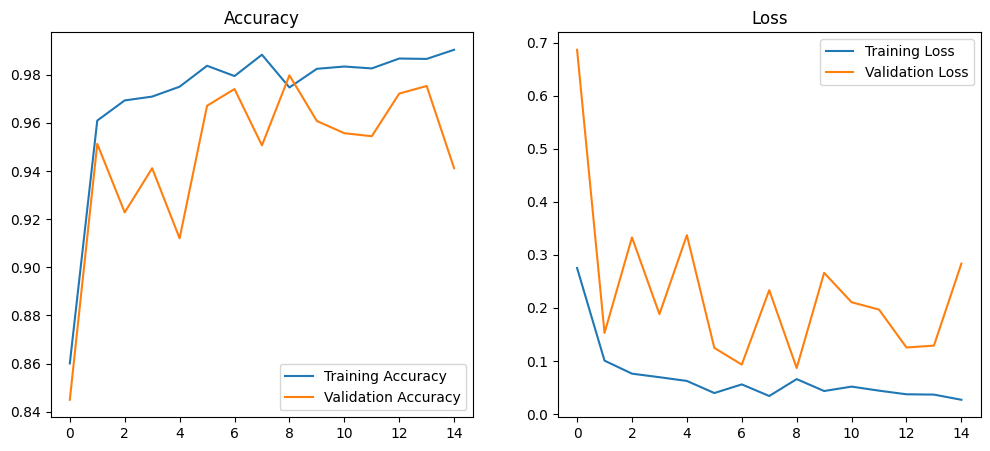

In [27]:
# --- 7. Trenowanie z użyciem CLASS WEIGHTS ---
epochs = 15 # Przy większej ilości danych trening może trwać ciut dłużej
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight=class_weights # <--- TU DZIEJE SIĘ MAGIA BALANSOWANIA
)

# --- 8. Zapis modelu ---
model.save("pokemon_vs_animal_weighted.keras")
print("\nModel zapisano jako 'pokemon_vs_animal_weighted.keras'")
# --- 9. Wykresy ---
def plot_training_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.plot(epochs_range, acc, label='Training Accuracy')
    ax1.plot(epochs_range, val_acc, label='Validation Accuracy')
    ax1.set_title('Accuracy')
    ax1.legend(loc='lower right')

    ax2.plot(epochs_range, loss, label='Training Loss')
    ax2.plot(epochs_range, val_loss, label='Validation Loss')
    ax2.set_title('Loss')
    ax2.legend(loc='upper right')

    plt.show()

plot_training_curves(history)

In [33]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
def predict_folder_visual(folder_path, model, max_images=9):
    dir_path = pathlib.Path(folder_path)
    image_files = [f for f in dir_path.iterdir() if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]
    image_files = image_files[:max_images] # Ograniczenie ilości wyświetlanych zdjęć

    plt.figure(figsize=(15, 15))

    for i, img_path in enumerate(image_files):
        # Wczytanie
        img = image.load_img(img_path, target_size=(256, 256))
        img_array = image.img_to_array(img)
        img_input = np.expand_dims(img_array, axis=0)

        # Predykcja
        prediction = model.predict(img_input, verbose=0)[0][0]

        if prediction > 0.5:
            label = f"Zwierzę ({prediction*100:.1f}%)"
            color = "green"
        else:
            label = f"Pokemon ({(1-prediction)*100:.1f}%)"
            color = "blue"

        # Wykres
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(f"{img_path.name}\n{label}", color=color, fontsize=12)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Użycie


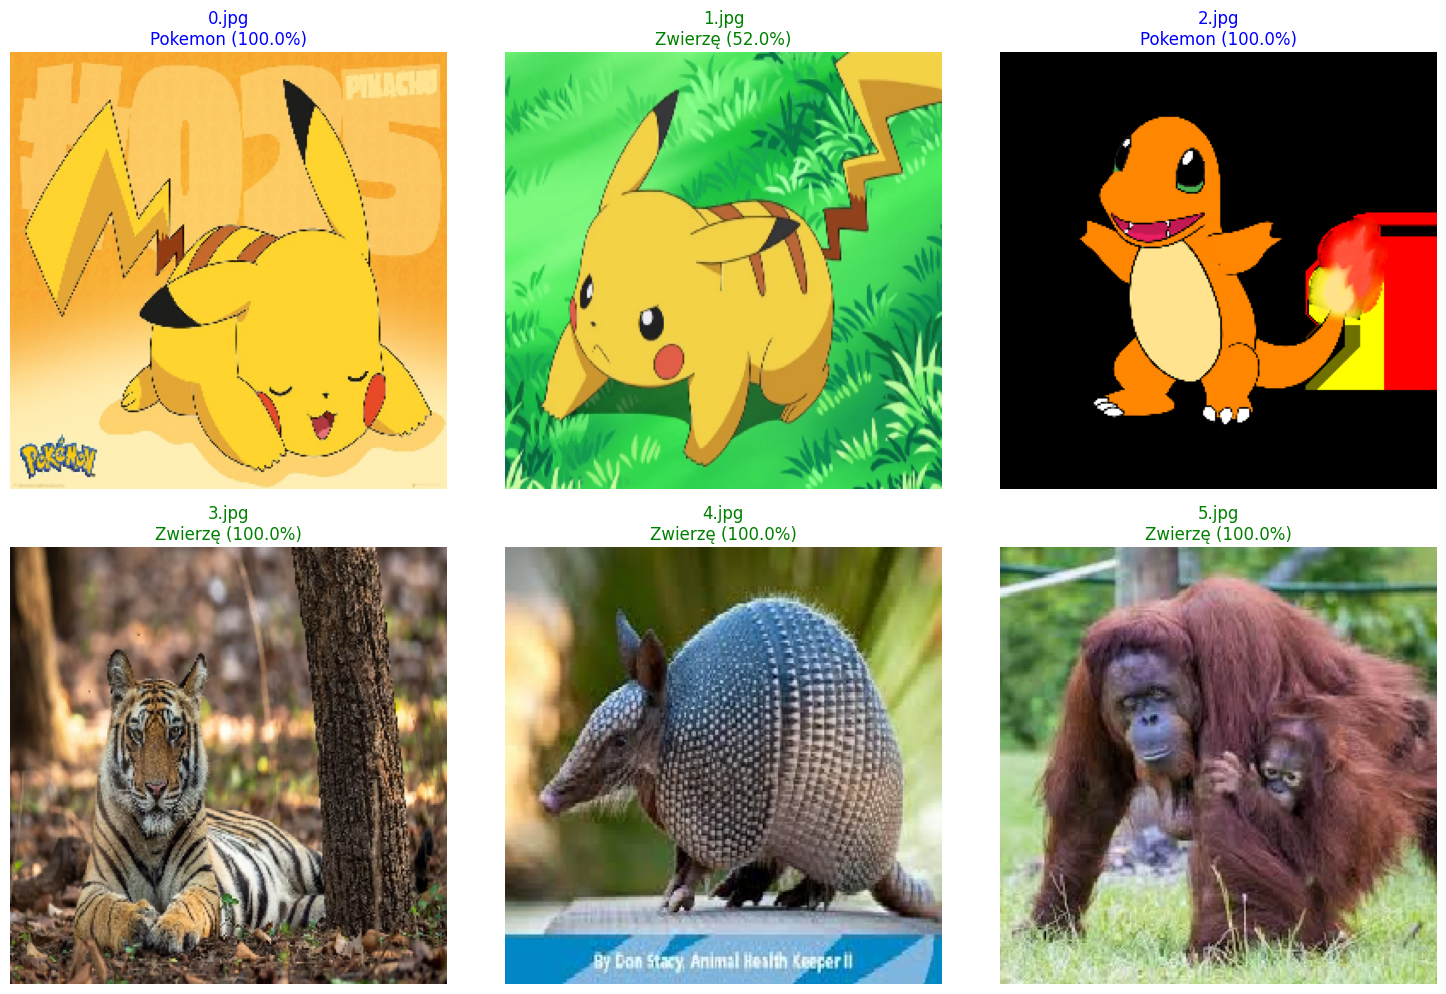

In [34]:
predict_folder_visual("test_images", model)
